In [1]:
import numpy as np 
import pandas as pd

In [2]:
movies= pd.read_csv('../dataset/movielens-1m/movies.csv', delimiter='::', engine='python')
ratings = pd.read_csv('../dataset/movielens-1m/ratings.csv', delimiter='::', engine='python')
users = pd.read_csv('../dataset/movielens-1m/users.csv', delimiter='::', engine='python')

In [3]:
movies.head()
# users.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# There should be :3883*6040 = 23453320 rtings
# left out ratings: 23453320 - 1000209 = 22453111

In [4]:
movies.isnull().sum()

MovieID    0
Title      0
Genres     0
dtype: int64

In [7]:
ratings.duplicated().sum()

0

Users that has rated more than 150 movies.

In [20]:
check3 = pd.DataFrame(ratings.groupby('UserID')['Ratings'].count())
# x = check3.loc[ : , :] > 250  
check3
x = check3.index[check3.loc[:, 'Ratings'] > 150]
check3

,Ratings
UserID,
1,53
2,129
3,51
4,21
5,198
...,...
6036,888
6037,202
6038,20


In [15]:
x

Int64Index([   5,   10,   15,   17,   18,   19,   22,   23,   26,   33,
            ...
            6007, 6010, 6011, 6016, 6018, 6025, 6035, 6036, 6037, 6040],
           dtype='int64', name='UserID', length=2084)

In [14]:
ratings

,UserID,MovieID,Ratings,TimeStamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [16]:
df_filtered_user = ratings[ratings['UserID'].isin(x)]
df_filtered_user

,UserID,MovieID,Ratings,TimeStamp
254,5,2987,4,978243170
255,5,2333,4,978242607
256,5,1175,5,978244759
257,5,39,3,978245037
258,5,288,2,978246585
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [21]:
movies.describe()

,MovieID
count,3883.000000
mean,1986.049446
std,1146.778349
min,1.000000
25%,982.500000
50%,2010.000000
75%,2980.500000
max,3952.000000


In [24]:

count_df = pd.DataFrame(ratings.groupby('MovieID')['Ratings'].count())
mean_df =  pd.DataFrame(ratings.groupby('MovieID')['Ratings'].mean())
# mean_df.shape
# mean_df
count_df.sort_values('Ratings')

,Ratings
MovieID,
402,1
2214,1
3382,1
2217,1
2218,1
...,...
480,2672
1210,2883
1196,2990


Check movies who has less than 50 ratings.

In [25]:
check = pd.concat((mean_df, count_df['Ratings'].rename('Number of rating')), axis=1)
# np.sum(check['Number of rating'].values == 0)
np.sum(check['Number of rating']<50)

1192

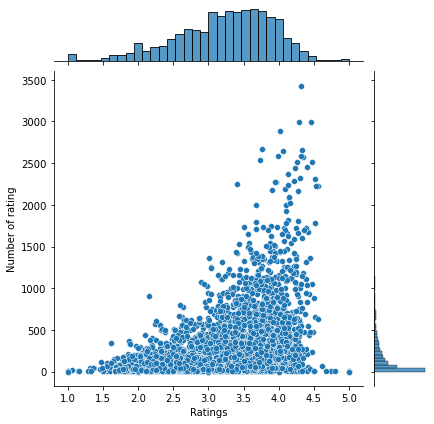

In [27]:
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
sns.jointplot(x='Ratings', y='Number of rating', data=check)

In [14]:
# user_item = ratings.pivot(index = 'UserID', columns = 'MovieID', values = 'Ratings').fillna(0)

In [28]:
import collections
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split, cross_validate
# from surprise.model_selection.split import LeaveOneOut
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import GridSearchCV




In [29]:
model_df = ratings.merge(movies, on='MovieID')

In [30]:
model_df

,UserID,MovieID,Ratings,TimeStamp,Title,Genres
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...
1000204,5949,2198,5,958846401,Modulations (1998),Documentary
1000205,5675,2703,3,976029116,Broken Vessels (1998),Drama
1000206,5780,2845,1,958153068,White Boys (1999),Drama
1000207,5851,3607,5,957756608,One Little Indian (1973),Comedy|Drama|Western


In [31]:
min_rating = ratings.Ratings.min()
max_rating = ratings.Ratings.max()

## Training Dataset

In [32]:
reader = Reader(rating_scale=(min_rating, max_rating))

data = Dataset.load_from_df(model_df[['UserID', 'MovieID', 'Ratings']], reader)
# trainSet = data.build_full_trainset()\

In [33]:
trainset, testset = train_test_split(data, test_size=.25)

## Modeling

In [34]:
# LOOCV = LeaveOneOut(n_splits=1, random_state=0)
# for train, test in LOOCV.split(data):
#     LOOCVTrain = train
#     LOOCVTest = test

# LOOCVAntiTestSet = LOOCVTrain.build_anti_testset()

# Compute similarty matrix between items so we can measure diversity
# sim_options = {'name': 'cosine', 'user_based': False}
svd_model = SVD(n_factors=100, n_epochs=30, lr_all= 0.005, reg_all= 0.4,)
# self.simsAlgo.fit(self.fullTrainSet)

In [35]:
svd_model.fit(trainset)

In [27]:
# Use 75% of the dataset for training and 25% for testing

# trainSet, testSet = train_test_split(data, test_size=0.25)
predictions = svd_model.test(testset)
check = pd.DataFrame(predictions)
check.sort_values(by=["est"], inplace=True, ascending=False)
recipe_list = check.head(10)['iid'].tolist()
recipe_list


NameError: name 'testset' is not defined

In [42]:
svd_model.pu.shape

(6040, 100)

In [43]:
svd_model.qi.shape

(3670, 100)

In [44]:
accuracy.rmse(predictions)

RMSE: 0.8771


0.8771369227131497

In [45]:
results = cross_validate(svd_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8736  0.8739  0.8733  0.8750  0.8709  0.8733  0.0014  
MAE (testset)     0.6851  0.6862  0.6857  0.6873  0.6840  0.6856  0.0011  
Fit time          10.02   10.78   10.16   10.06   10.59   10.32   0.30    
Test time         2.08    1.64    1.57    1.70    1.89    1.78    0.18    


In [46]:
print("Average MAE: ", np.average(results["test_mae"]))
print("Average RMSE: ", np.average(results["test_rmse"]))

Average MAE:  0.685646585903401
Average RMSE:  0.8733158465438663


Hyperparameter Tuning

In [36]:
param_grid = {'n_epochs': [ 20, 30], 'lr_all': [0.001, 0.005, 0.1],
              'reg_all': [0.4, 0.6], 'n_factors': [100, 200]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9285736275543642
{'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.4, 'n_factors': 100}


Retraining Model using best params:

In [ ]:
#best hyperparameters
best_factor = gs.best_params['rmse']['n_factors']
best_epoch = gs.best_params['rmse']['n_epochs']
 
# sample random trainset and testset
# trainset, testset = train_test_split(data, test_size=.20)
 
# We'll use the famous SVD algorithm.
svd = SVD(n_factors=best_factor, n_epochs=best_epoch)
 
# Train the algorithm on the trainset
svd.fit(trainset)

## Recommending Movies

In [57]:
ratings[ratings['UserID']==100].iloc[:,1] 

12900     648
12901     800
12902    3948
12903    1408
12904    1196
         ... 
12971    1221
12972    2028
12973     480
12974    1304
12975    2115
Name: MovieID, Length: 76, dtype: int64

In [11]:
user_id = 100

In [36]:
def recommend_movies(model, ratings, user_id, n_items):
    dicti = {}
    movieIDS = ratings["MovieID"].unique()
    #movies that user has rated.
    movieIDS_user_seen = ratings.loc[ratings["UserID"] == user_id, 'MovieID']
    movieIdS_user_notseen = np.setdiff1d(movieIDS, movieIDS_user_seen)
    test_set = [[user_id, movie_id, 0] for movie_id in movieIdS_user_notseen]
    predictions = model.test(test_set)
    pred_ratings = np.array([pred.est for pred in predictions])
    movie_id_predicted = np.array([pred.iid for pred in predictions])
    sorted_index_movies = np.argsort(-pred_ratings)[:n_items]
    for i, idx in enumerate(sorted_index_movies):
        movie = movies[movies["MovieID"]==idx].iloc[:, :].values[0]
        dicti[i] = [movie[1], movie[2], pred_ratings[idx]]
    return dicti


In [38]:
recommend_movies(svd_model, ratings, user_id, 10)

{0: ["Besieged (L' Assedio) (1998)", 'Drama', 3.9388870127878954],
 1: ['Unhook the Stars (1996)', 'Drama', 3.8354871211881254],
 2: ['Seven (Se7en) (1995)', 'Crime|Thriller', 3.827485774033491],
 3: ['King of New York (1990)', 'Action|Crime', 3.8241445079630627],
 4: ['Operation Dumbo Drop (1995)',
  'Action|Adventure|Comedy|War',
  3.817226773515864],
 5: ['Matilda (1996)', "Children's|Comedy", 3.812549217995635],
 6: ['Death in the Garden (Mort en ce jardin, La) (1956)',
  'Drama',
  3.792942091396702],
 7: ['Allan Quartermain and the Lost City of Gold (1987)',
  'Action|Adventure',
  3.7885391088549754],
 8: ['Parent Trap, The (1961)', "Children's|Drama", 3.7654857878926427],
 9: ['Meatballs (1979)', 'Comedy', 3.7633789552622843]}

In [39]:
print(recommend_movies(svd_model, ratings, user_id, n_items=10))

{0: ["Besieged (L' Assedio) (1998)", 'Drama', 3.9388870127878954], 1: ['Unhook the Stars (1996)', 'Drama', 3.8354871211881254], 2: ['Seven (Se7en) (1995)', 'Crime|Thriller', 3.827485774033491], 3: ['King of New York (1990)', 'Action|Crime', 3.8241445079630627], 4: ['Operation Dumbo Drop (1995)', 'Action|Adventure|Comedy|War', 3.817226773515864], 5: ['Matilda (1996)', "Children's|Comedy", 3.812549217995635], 6: ['Death in the Garden (Mort en ce jardin, La) (1956)', 'Drama', 3.792942091396702], 7: ['Allan Quartermain and the Lost City of Gold (1987)', 'Action|Adventure', 3.7885391088549754], 8: ['Parent Trap, The (1961)', "Children's|Drama", 3.7654857878926427], 9: ['Meatballs (1979)', 'Comedy', 3.7633789552622843]}


Saving model with Pickle


In [40]:
import pickle
pickle.dump(svd_model, open('svd100_30_0.005_0.4.pkl', 'wb'))


In [43]:
dicti = {}
movieIDS = ratings["MovieID"].unique()
#movies that user has rated.
movieIDS_user_seen = ratings.loc[ratings["UserID"] == user_id, 'MovieID']
print(len(movieIDS_user_seen))
movieIdS_user_notseen = np.setdiff1d(movieIDS, movieIDS_user_seen)
test_set = [[user_id, movie_id, 0] for movie_id in movieIdS_user_notseen]
predictions = svd_model.test(test_set)
pred_ratings = np.array([pred.est for pred in predictions])
# movie_id_predicted = np.array([pred.iid for pred in predictions])
sorted_index_movies = np.argsort(-pred_ratings)[:10]
for i, idx in enumerate(sorted_index_movies):
    movie = movies[movies["MovieID"]==idx].iloc[:, :].values[0]
    dicti[i] = [movie[1], movie[2], pred_ratings[idx]]


In [70]:
ratings['UserID'].unique()

array([   1,    2,    3, ..., 6038, 6039, 6040], dtype=int64)